<a href="https://colab.research.google.com/github/camminady/sPYnning/blob/master/visworld_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install randomcolor 
import randomcolor # see: https://pypi.org/project/randomcolor/
!pip install gif
import gif # see https://github.com/maxhumber/gif
!pip install reverse_geocoder
import reverse_geocoder as rg # see ttps://pypi.org/project/reverse_geocoder/

import numpy as np

# plotting
import matplotlib 
import matplotlib.pyplot as plt
from matplotlib import cm, colors

# 3d
!sudo apt-get install libgeos-dev
!sudo pip3 install https://github.com/matplotlib/basemap/archive/master.zip
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# everything below is used to color the globe
from mpl_toolkits.basemap import Basemap
import json
import requests


  Created wheel for randomcolor: filename=randomcolor-0.4.4.5-cp36-none-any.whl size=4850 sha256=0fedbd4bf9950c8bb675530e1d0c5fb44cdc5189fd0bd25a862735ed82252e4d
  Stored in directory: /root/.cache/pip/wheels/29/a0/6a/2e8eee7beec10d69f27acd13d87f631a089ac4f8352f1359d9
Successfully built randomcolor
  Created wheel for gif: filename=gif-2.0.0-cp36-none-any.whl size=3612 sha256=43420b5ded5548a4339a31ef0ef4a172fd9e629fd0ca5ec0d35f90fb389bf005
  Stored in directory: /root/.cache/pip/wheels/28/0c/ce/467409b9cfeb724bc80753f91414041ec1a193d02c31ce468f
Successfully built gif
     |████████████████████████████████| 2.3MB 2.6MB/s 
  Created wheel for reverse-geocoder: filename=reverse_geocoder-1.5.1-cp36-none-any.whl size=2268091 sha256=493d18fda9399613ff2ba3db15b33867dc11f6c258623cd95fa48d9f6f22c303
  Stored in directory: /root/.cache/pip/wheels/47/05/50/b1350ff094ef91e082665b4a2f9ca551f8acea4aa55d796b26
Successfully built reverse-geocoder
Reading package lists... Done
Building dependency tree 

In [2]:
from numpy import loadtxt, degrees, arcsin, arctan2, sort, unique
from mpl_toolkits.basemap import Basemap
import reverse_geocoder as rg
import randomcolor

def domino(lol):
    # Takes a list (length n) of lists (length 2)
    # and returns a list of indices order,
    # such that lol[order[i]] and lol[order[i+1]]
    # have at least one element in common.
    # If that is not possible, multiple
    # domino chains will be created.
    # This works in a greedy way.
    
    n = len(lol)
    order = [0] # Greedy 
    link = lol[0][-1]
    links = [lol[0][0],lol[0][1]]
    while len(order)<n:
        for i in [j for j in range(n) if not j in order]:
            if link in lol[i]: # They connect
                order.append(i) # Save the id of the "stone"
                link = lol[i][0] if not(lol[i][0]==link) else lol[i][1] # The new link is the other element 
                links.append(link)
                break
    return order,links[:-1]


def getpatches(color,quadrature):
    xyz,neighbours,triangles = quadrature["xyz"], quadrature["neighbours"], quadrature["triangles"]
    nq = len(color)
    patches = []
    for center in range(nq):
        lol = [] # list of lists
        for i in neighbours[center,:]:
            if i>-1:
                lol.append(list(sort(triangles[i,triangles[i,:] != center])))
        order,links = domino(lol)

        neighx = [xyz[j,0] for j in links]
        neighy = [xyz[j,1] for j in links]
        neighz = [xyz[j,2] for j in links]

        # Get the actual hexagon that surrounds a center point
        x = []
        y = []
        z = []
        for i in range(len(order)):
            x.append((xyz[center,0]+neighx[i]) / 2)
            x.append((xyz[center,0]+neighx[i]+neighx[(i+1)%len(order)])/3)

            y.append((xyz[center,1]+neighy[i]) / 2)
            y.append((xyz[center,1]+neighy[i]+neighy[(i+1)%len(order)])/3)

            z.append((xyz[center,2]+neighz[i]) / 2)
            z.append((xyz[center,2]+neighz[i]+neighz[(i+1)%len(order)])/3)

        verts = [list(zip(x,y,z))]
        patches.append(verts[0])
    return patches


def getquadrature(nq):
    prefix ="https://raw.githubusercontent.com/camminady/sPYnning/master/"
    quadrature = {}
    quadrature["nq"] = nq
    quadrature["xyz"] = loadtxt(f"{prefix}quadrature/{nq}/points.txt")
    quadrature["weights"] = loadtxt(f"{prefix}quadrature/{nq}/weights.txt")
    quadrature["neighbours"] = loadtxt(f"{prefix}quadrature/{nq}/neighbours.txt",dtype=int)-1 # julia starts at 1
    quadrature["triangles"] = loadtxt(f"{prefix}quadrature/{nq}/triangles.txt",dtype=int)-1 # julia starts at 1 
    
    # Also convert to latitute, longitude
    quadrature["lat"] = degrees(arcsin(quadrature["xyz"][:,2]/1))
    quadrature["lon"] = degrees(arctan2(quadrature["xyz"][:,1], quadrature["xyz"][:,0]))

    return quadrature



def color_land(quadrature):
    bm = Basemap()  
    colors = []
    for i,(ypt, xpt) in enumerate(zip(quadrature["lat"],quadrature["lon"])):
        land = (bm.is_land(xpt,ypt))  
        colors.append("tab:green" if land else "tab:blue")
    return colors

def color_country(quadrature):
    # uses reverse_geocoder
    results = rg.search([(la,lo) for la,lo in zip(quadrature["lat"],quadrature["lon"])]) # default mode = 2
    countries = []
    for i in range(len(results)):
        c = results[i]["cc"]
        countries.append(c)
    nunique = len(unique(countries))
    
    raco = randomcolor.RandomColor()
    randomcolors = raco.generate(luminosity="dark", count=nunique) # options: https://github.com/kevinwuhoo/randomcolor-py
    colordict = dict(zip(unique(countries),randomcolors))
    colorland = color_land(quadrature) # so we can color the ocean also in "tab:blue"
    colorcountries = [colordict[country] if colorland[i]!="tab:blue" else "tab:blue" for i,country in enumerate(countries) ]
    return colorcountries

In [3]:
@gif.frame
def myplot(color,quadrature, filename, angle=30):
    
    patches = getpatches(color,quadrature) # Get the hexagons 
    
    fig = plt.figure(figsize=plt.figaspect(1)*2,constrained_layout=False) 
    ax = fig.gca(projection='3d')
    
    # Visualize each hexagon, that is given in "color". A color is computed
    # for the center of the hexagon and then applied for the full hexagon
    ax.add_collection3d(Poly3DCollection(patches,facecolor = color,linewidth=0.1,edgecolor=color))
        
    # Some styling
    l = 0.6
    plt.axis("off")
    ax.set_xlim([-l,l]), ax.set_ylim([-l,l]),ax.set_zlim([-l,l])
    ax.set_xticks([]), ax.set_yticks([]), ax.set_zticks([])
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    for spine in ax.spines.values():
        spine.set_visible(False)
    plt.tight_layout()
    ax.view_init(30, angle)
    fig.savefig(filename)

In [4]:
# pick the number of cells on the globe from this list
# [92, 492, 1212, 2252, 3612, 5292, 7292, 9612, 12252, 15212]
nq = 2252
quadrature = getquadrature(nq)

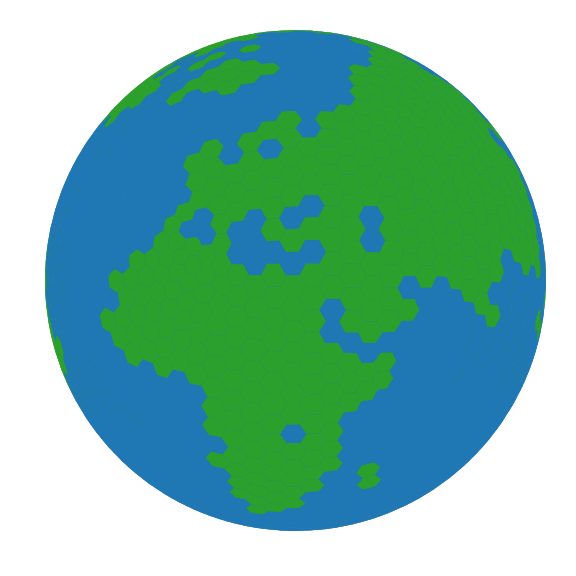

In [5]:
# plot the earth 
colors  = color_land(quadrature)
myplot(colors,quadrature,"earth.png")

Loading formatted geocoded file...


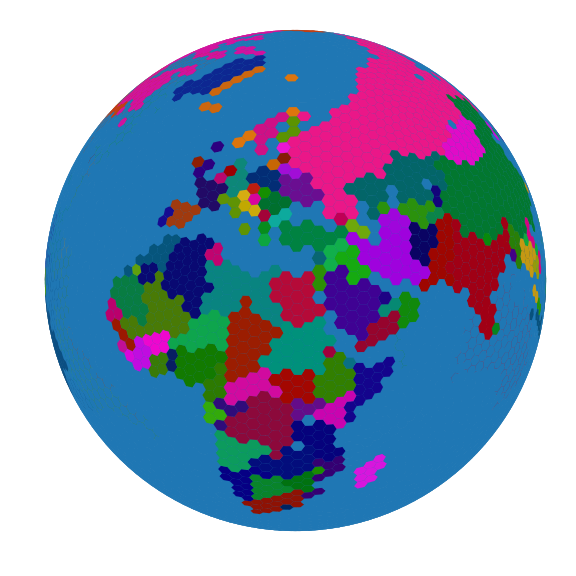

In [6]:
# higher resolution to plot countries
nq = 7292
quadrature = getquadrature(nq)
colors  = color_country(quadrature)
myplot(colors,quadrature,"earth_country.png")


In [7]:
# creating a gif
nq = 7292
quadrature = getquadrature(nq)
colors  = color_land(quadrature)

frames = []
nframes = 20 # the more, the slower 
for i,angle in enumerate(np.linspace(0,360,nframes)[:-1]):
    print(i,end=",")
    frames.append(myplot(colors,quadrature,"tmp.png",angle=angle))

gif.save(frames,"spinning_earth.gif")

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,